In [3]:
%reload_ext autoreload
%autoreload 2

import cv2

import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from collections import defaultdict

from matplotlib.path import Path
%matplotlib inline

In [4]:
label_polygon = pickle.load(open(os.environ['REPO_DIR']+'/database/label_polygon.pkl', 'r'))

In [5]:
first, last = section_range_lookup['MD589']
dms = dict([(sc, DataManager(stack='MD589', section=sc, segm_params_id='tSLIC200', load_mask=False)) 
            for sc in range(first, last)])

In [6]:
print label_polygon.keys()

['PrVv', 'Vcd', 'BC', 'CereNuc', '7n', 'DC', 'PrVd', '5N', 'RtTg', 'PnO', 'Tz', 'Pn', 'scp', 'SuVe', 'Pr5VL', 'VLL', '9N', '7N', 'Amb', '12N', 'Pr5', '5TT', 'Sp5O', 'VCA', 'UDFtr', 'VIpp', 'TrVdes', 'VOrp', 'Sp5C', 'sp5', 'VCP', 'VOri', 'R', 'LRt', 'IO', '10N', 'VOra', 'VMu', 'Pr5DM', 'MVePC', 'Gr', 'VTg', 'LC', 'Sp5I', 'Sol', '6N', 'LVe', 'UDF', 'MVe', 'LSO', 'LDTg']


In [89]:
#label = 'Pn'
# label = '12N'
# label = 'Gr'
# label = "7N"
# label = '7n'
# label = "5N"
# label = 'sp5'
# label = 'VLL'
# label = 'LVe'
label = 'SuVe'

In [90]:
landmark_images = {}
adjusted_vertices = {}

for i, sec in enumerate(sorted(label_polygon[label].keys())):
    
    print sec
    
    vertices = np.array(label_polygon[label][sec])
    
    xmin, ymin  = np.min(vertices, axis=0).astype(np.int) - 300
    xmax, ymax  = np.max(vertices, axis=0).astype(np.int) + 300
    
    dms[sec]._load_image(['rgb-jpg'])
    viz = dms[sec].image_rgb_jpg[ymin:ymax+1, xmin:xmax+1].copy()
    landmark_images[sec] = viz
    del dms[sec].image_rgb_jpg
    
    adjusted_vertices[sec] = vertices - (xmin, ymin)

79
80
81
82
83
84
85
86


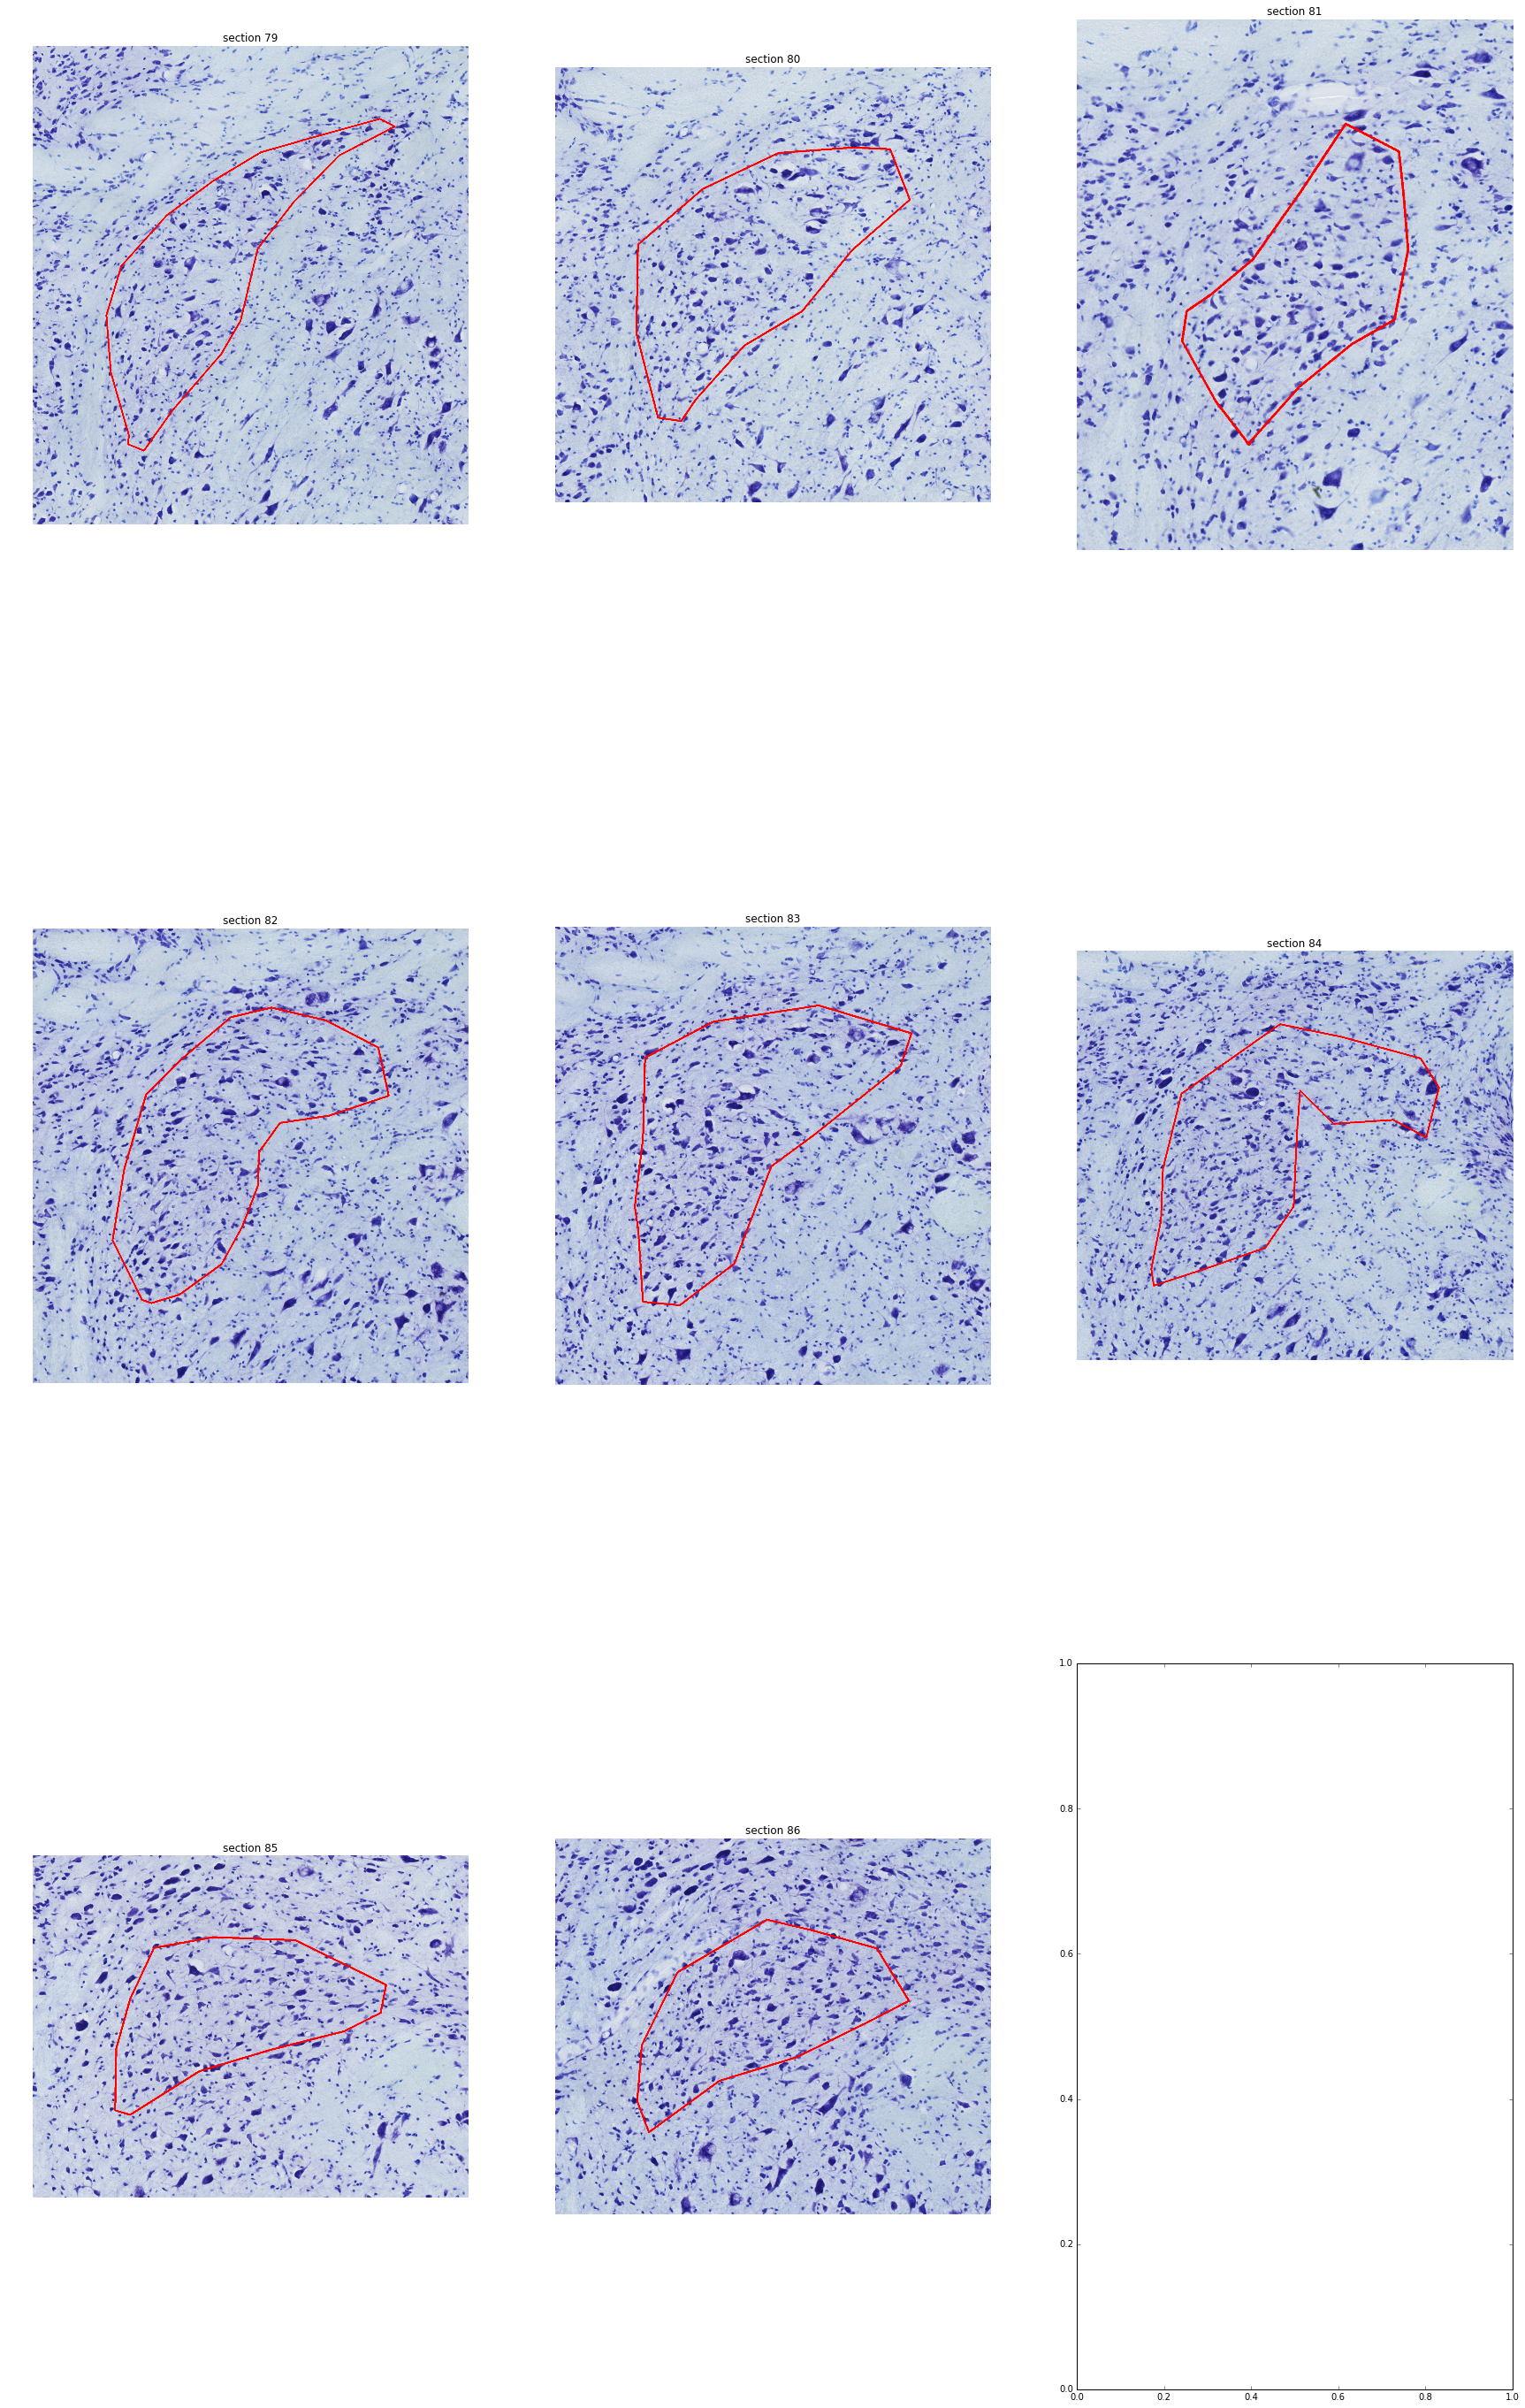

In [91]:
ncol = 3

nimgs = len(label_polygon[label])

fig, axes = plt.subplots(int((nimgs-1)/ncol)+1, ncol, figsize=(30,50), squeeze=True)
axes = axes.flatten()
# axes = np.atleast_1d(axes)

for i, sec in enumerate(sorted(label_polygon[label].keys())):
    
    vs = adjusted_vertices[sec]
    viz = landmark_images[sec].copy()
    cv2.polylines(viz, [np.int32(vs)], True, (255,0,0), 5)
    axes[i].imshow(viz)
    axes[i].set_title('section %d' % sec)
    axes[i].axis('off')
    
plt.show()


In [92]:
patch_size = 100
half_size = patch_size/2
stride = 50

patches_allSections = {}
patches = []
for i, sec in enumerate(sorted(label_polygon[label].keys())):
    h, w = landmark_images[sec].shape[:2]
    ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride))
    polygon_path = Path(adjusted_vertices[sec])
    for x, y in np.c_[xs.flat, ys.flat]:
        if np.all(polygon_path.contains_points([(x-half_size, y-half_size),(x+half_size, y-half_size),
                                                (x+half_size, y+half_size),(x-half_size, y+half_size)])):
            patch = landmark_images[sec][y-half_size:y+half_size, x-half_size:x+half_size].copy()
            patches.append(patch)
    patches_allSections[sec] = patches

7776 patches


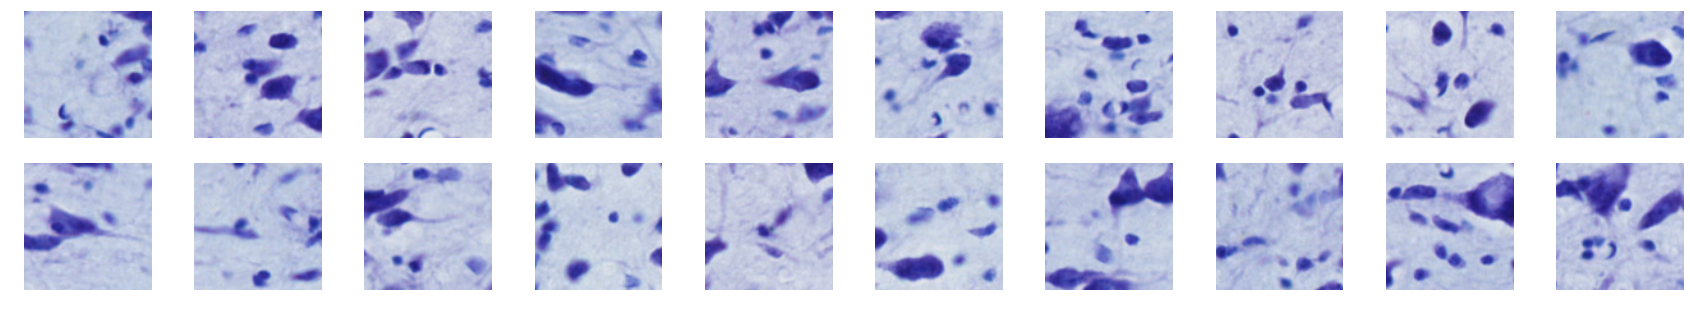

In [93]:
all_patches = [p for sec, patches in patches_allSections.iteritems() for p in patches]
print len(all_patches), 'patches'

# randomly visualize a few patches
nimgs = 20
ncol = 10
fig, axes = plt.subplots(int((nimgs-1)/ncol)+1, ncol, figsize=(30,5), squeeze=True)
axes = axes.flatten()

for i, patch_ind in enumerate(np.random.randint(0, len(all_patches), nimgs)):
    axes[i].imshow(all_patches[patch_ind])
    axes[i].axis('off')

In [94]:
fewer_patches = [all_patches[i] for i in np.random.choice(range(len(all_patches)), 10000)]

In [95]:
fewer_patches_arr = np.array(map(rgb2gray, fewer_patches), np.uint8)

In [96]:
np.save(label+'_patches.npy', fewer_patches_arr)

In [30]:
# filters = Filters(complevel=9, complib='blosc')
# with open_file(label+'_patches.hdf', mode="w") as f:
#     _ = f.create_carray('/', 'data', Atom.from_dtype(fewer_patches_arr.dtype), filters=filters, obj=fewer_patches_arr)